In [43]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
sys.path.append(os.path.abspath('../src'))

In [44]:
from load_data import load_data_using_sqlalchemy
from utils import missing_values_table, convert_bytes_to_megabytes, outliers_table, fix_outlier, convert_ms_to_seconds

In [45]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [46]:
# filtering columns that are needed for user experience analysis
columns = [
    'IMSI',
    'Handset Type',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)'
]


# Create the df DataFrame with the selected columns
df = df[columns].copy()

EDA on the data frame

In [47]:
df.shape

(150001, 8)

In [48]:
df.head()

,IMSI,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,2.082014e+14,Samsung Galaxy A5 Sm-A520F,42.0,5.0,23.0,44.0,NaN,NaN
1,2.082019e+14,Samsung Galaxy J5 (Sm-J530),65.0,5.0,16.0,26.0,NaN,NaN
2,2.082003e+14,Samsung Galaxy A8 (2018),NaN,NaN,6.0,9.0,NaN,NaN
3,2.082014e+14,undefined,NaN,NaN,44.0,44.0,NaN,NaN
4,2.082014e+14,Samsung Sm-G390F,NaN,NaN,6.0,9.0,NaN,NaN


In [49]:
df.info

<bound method DataFrame.info of                 IMSI                 Handset Type  Avg RTT DL (ms)  \
0       2.082014e+14   Samsung Galaxy A5 Sm-A520F             42.0   
1       2.082019e+14  Samsung Galaxy J5 (Sm-J530)             65.0   
2       2.082003e+14     Samsung Galaxy A8 (2018)              NaN   
3       2.082014e+14                    undefined              NaN   
4       2.082014e+14             Samsung Sm-G390F              NaN   
...              ...                          ...              ...   
149996  2.082022e+14  Apple iPhone 8 Plus (A1897)             32.0   
149997  2.082019e+14      Apple iPhone Se (A1723)             27.0   
149998  2.082017e+14      Apple iPhone Xs (A2097)             43.0   
149999  2.082021e+14               Huawei Fig-Lx1             37.0   
150000           NaN                         None              NaN   

        Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  \
0                   5.0                     23.0  

In [50]:
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values,Dtype
TCP UL Retrans. Vol (Bytes),96649,64.4,float64
TCP DL Retrans. Vol (Bytes),88146,58.8,float64
Avg RTT DL (ms),27829,18.6,float64
Avg RTT UL (ms),27812,18.5,float64
Handset Type,572,0.4,object
IMSI,570,0.4,float64
Avg Bearer TP DL (kbps),1,0.0,float64
Avg Bearer TP UL (kbps),1,0.0,float64


In [51]:
df.dropna(subset=['IMSI'], inplace=True)
df.dropna(subset=['Handset Type'], inplace=True)

# Calculate mean values
mean_rtt_dl = df['TCP UL Retrans. Vol (Bytes)'].mean()
mean_rtt_ul = df['TCP DL Retrans. Vol (Bytes)'].mean()
mean_rtt_dl = df['Avg RTT UL (ms)'].mean()
mean_rtt_ul = df['Avg RTT DL (ms)'].mean()

# Fill missing values with mean
df.update(df['Avg RTT DL (ms)'].fillna(mean_rtt_dl))
df.update(df['Avg RTT UL (ms)'].fillna(mean_rtt_ul))
df.update(df['TCP UL Retrans. Vol (Bytes)'].fillna(mean_rtt_dl))
df.update(df['TCP DL Retrans. Vol (Bytes)'].fillna(mean_rtt_ul))

missing_values_table(df)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


In [52]:
# Desplay the number of outlayers Values in the dataset 
df = pd.DataFrame(df) 
outliers_table(df)

Your selected dataframe has 8 columns.
Outlier information for numerical columns is displayed below.


,Column,Z-Score Outliers,IQR Outliers
0,IMSI,3,13248
1,Avg RTT DL (ms),827,14855
2,Avg RTT UL (ms),649,30203
3,Avg Bearer TP DL (kbps),2973,13164
4,Avg Bearer TP UL (kbps),4254,21477
5,TCP DL Retrans. Vol (Bytes),549,31529
6,TCP UL Retrans. Vol (Bytes),97,28859


In [53]:
columns_to_apply_quartiles = ['Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)']

In [54]:
# Apply the fix_outlier function to each specified column
for column in columns_to_apply_quartiles:
    if column in df.columns:
        df[column] = fix_outlier(df, column)

In [56]:
millisecond_columns = [
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)']

In [57]:
for column in millisecond_columns:
    df[column] = convert_ms_to_seconds(df[column])

# renaming the column
df.rename(columns=lambda x: x.replace('(ms)', '(s)') if '(ms)' in x else x, inplace=True)

In [58]:
byte_columns = [
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)']

In [59]:
for column in byte_columns:
    df[column] = convert_ms_to_seconds(df[column])


# renaming the column
df.rename(columns=lambda x: x.replace('Bytes', 'Megabytes') if 'Bytes' in x else x, inplace=True)

In [60]:
df.head()

,IMSI,Handset Type,Avg RTT DL (s),Avg RTT UL (s),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Megabytes),TCP UL Retrans. Vol (Megabytes)
0,2.082014e+14,Samsung Galaxy A5 Sm-A520F,0.042000,0.00500,23.0,44.0,0.10811,0.017675
1,2.082019e+14,Samsung Galaxy J5 (Sm-J530),0.065000,0.00500,16.0,26.0,0.10811,0.017675
2,2.082003e+14,Samsung Galaxy A8 (2018),0.017675,0.10811,6.0,9.0,0.10811,0.017675
3,2.082014e+14,undefined,0.017675,0.10811,44.0,44.0,0.10811,0.017675
4,2.082014e+14,Samsung Sm-G390F,0.017675,0.10811,6.0,9.0,0.10811,0.017675


Computing top 10 of the top, bottom, and most frequent values

In [61]:
df['Total TCP Retransmission'] = df['TCP DL Retrans. Vol (Megabytes)'] + df['TCP UL Retrans. Vol (Megabytes)']
df['Total RTT'] = df['Avg RTT DL (s)'] + df['Avg RTT UL (s)']
df['Total Throughput'] = df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']

In [63]:
# The top, bottom, and most frequent values of TCP Retransmission

top_10_tcp = df['Total TCP Retransmission'].nlargest(10)
# Bottom 10 TCP Values
bottom_10_tcp = df['Total TCP Retransmission'].nsmallest(10)
# Most Frequent TCP Values
most_frequent_tcp = df['Total TCP Retransmission'].value_counts().head(10)

print("Top 10 TCP Retransmission Values:\n", top_10_tcp)
print("Bottom 10 TCP Retransmission Values:\n", bottom_10_tcp)
print("Most Frequent TCP Retransmission Values:\n", most_frequent_tcp)

Top 10 TCP Retransmission Values:
 36947     12373.590
61741     12345.315
142763    12338.489
9589      12331.118
133437    12325.218
136647    12317.954
124675    12314.767
138322    12304.418
120729    12295.643
66195     12276.315
Name: Total TCP Retransmission, dtype: float64
Bottom 10 TCP Retransmission Values:
 125091    0.019675
2850      0.021675
60376     0.021675
75095     0.021675
143429    0.021675
143707    0.021675
18455     0.023675
100355    0.023675
122612    0.023675
3024      0.025675
Name: Total TCP Retransmission, dtype: float64
Most Frequent TCP Retransmission Values:
 Total TCP Retransmission
0.125786    88220
1.402110      650
1.438110      272
1.347675      248
1.426110      144
0.055675      138
0.109675      131
2.677675      120
2.768110      115
1.335675      106
Name: count, dtype: int64


In [64]:
# top, bottom, and most frequent values of RTT Values

# Top 10 RTT Values
top_10_rtt = df['Total RTT'].nlargest(10)
# Bottom 10 RTT Values
bottom_10_rtt = df['Total RTT'].nsmallest(10)
# Most Frequent RTT Values
most_frequent_rtt = df['Total RTT'].value_counts().head(10)


print("\nTop 10 RTT Values:\n", top_10_rtt)
print("Bottom 10 RTT Values:\n", bottom_10_rtt)
print("Most Frequent RTT Values:\n", most_frequent_rtt)


Top 10 RTT Values:
 115199    0.316
34321     0.315
142524    0.314
69933     0.311
145543    0.305
137685    0.302
40938     0.300
39432     0.297
2248      0.295
40937     0.294
Name: Total RTT, dtype: float64
Bottom 10 RTT Values:
 42612     0.000
103326    0.000
124541    0.000
143878    0.000
71739     0.002
50974     0.004
144923    0.004
103549    0.005
8778      0.006
123213    0.006
Name: Total RTT, dtype: float64
Most Frequent RTT Values:
 Total RTT
0.125786    27665
0.039000     4005
0.029000     2927
0.040000     2920
0.038000     2133
0.029000     2075
0.031000     1974
0.041000     1917
0.047000     1869
0.048000     1800
Name: count, dtype: int64


In [65]:
# top, bottom, and most frequent values of Throughput Values

# Top 10 Throughput Values
top_10_throughput = df['Total Throughput'].nlargest(10)
# Bottom 10 Throughput Values
bottom_10_throughput = df['Total Throughput'].nsmallest(10)
# Most Frequent Throughput Values
most_frequent_throughput = df['Total Throughput'].value_counts().head(10)

print("\nTop 10 Throughput Values:\n", top_10_throughput)
print("Bottom 10 Throughput Values:\n", bottom_10_throughput)
print("Most Frequent Throughput Values:\n", most_frequent_throughput)


Top 10 Throughput Values:
 77757     72602.0
2369      72459.0
92303     72416.0
59333     72364.0
58701     72323.0
59743     72214.0
124005    72179.0
140933    72150.0
117626    71969.0
23306     71900.0
Name: Total Throughput, dtype: float64
Bottom 10 Throughput Values:
 149     0.0
364     0.0
618     0.0
756     0.0
1818    0.0
2489    0.0
3935    0.0
4166    0.0
4853    0.0
5821    0.0
Name: Total Throughput, dtype: float64
Most Frequent Throughput Values:
 Total Throughput
63.0     3886
15.0     3701
126.0    2763
97.0     1945
90.0     1882
98.0     1800
96.0     1671
99.0     1570
89.0     1556
91.0     1517
Name: count, dtype: int64


In [68]:
# average throughput per handset type

df['Avg Throughput'] = (df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']) / 2
df.groupby('Handset Type')['Avg Throughput'].mean().reset_index()

,Handset Type,Avg Throughput
0,A-Link Telecom I. Cubot A5,11755.000000
1,A-Link Telecom I. Cubot Note Plus,3349.500000
2,A-Link Telecom I. Cubot Note S,4468.500000
3,A-Link Telecom I. Cubot Nova,28108.500000
4,A-Link Telecom I. Cubot Power,202.500000
...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,29.000000
1392,Zyxel Communicat. Lte7460,19902.000000
1393,Zyxel Communicat. Sbg3600,63.000000
1394,Zyxel Communicat. Zyxel Wah7706,1086.500000


In [71]:
# distribution of average throughput per handset type

# Filter out handsets with very few entries
handset_counts = df['Handset Type'].value_counts()
filtered_handsets = handset_counts[handset_counts > 50].index  
df_filtered = df[df['Handset Type'].isin(filtered_handsets)]



In [73]:
df_filtered.loc[:, 'Avg Throughput'] = (df_filtered['Avg Bearer TP DL (kbps)'] + df_filtered['Avg Bearer TP UL (kbps)']) / 2
df_filtered.groupby('Handset Type')['Avg Throughput'].mean().sort_values().reset_index()

,Handset Type,Avg Throughput
0,Zte Mf259,85.311765
1,Apple iPhone 4 (A1332),623.302139
2,Apple iPhone 4S (A1387),834.289604
3,Samsung Galaxy Trend Lite (Gt-S7390),1060.137363
4,Samsung Galaxy Trend Lite 2 (Sm-G318X),1199.811321
...,...,...
128,Huawei E5573B,10425.529221
129,Xiaomi Communica. Redmi Note5,11048.057143
130,Huawei E5180,12836.441558
131,Huawei E5573,13716.500000


C:\Users\a\AppData\Local\Temp\ipykernel_10212\20468123.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg Throughput', y='Handset Type', data=throughput_per_handset, palette='viridis')


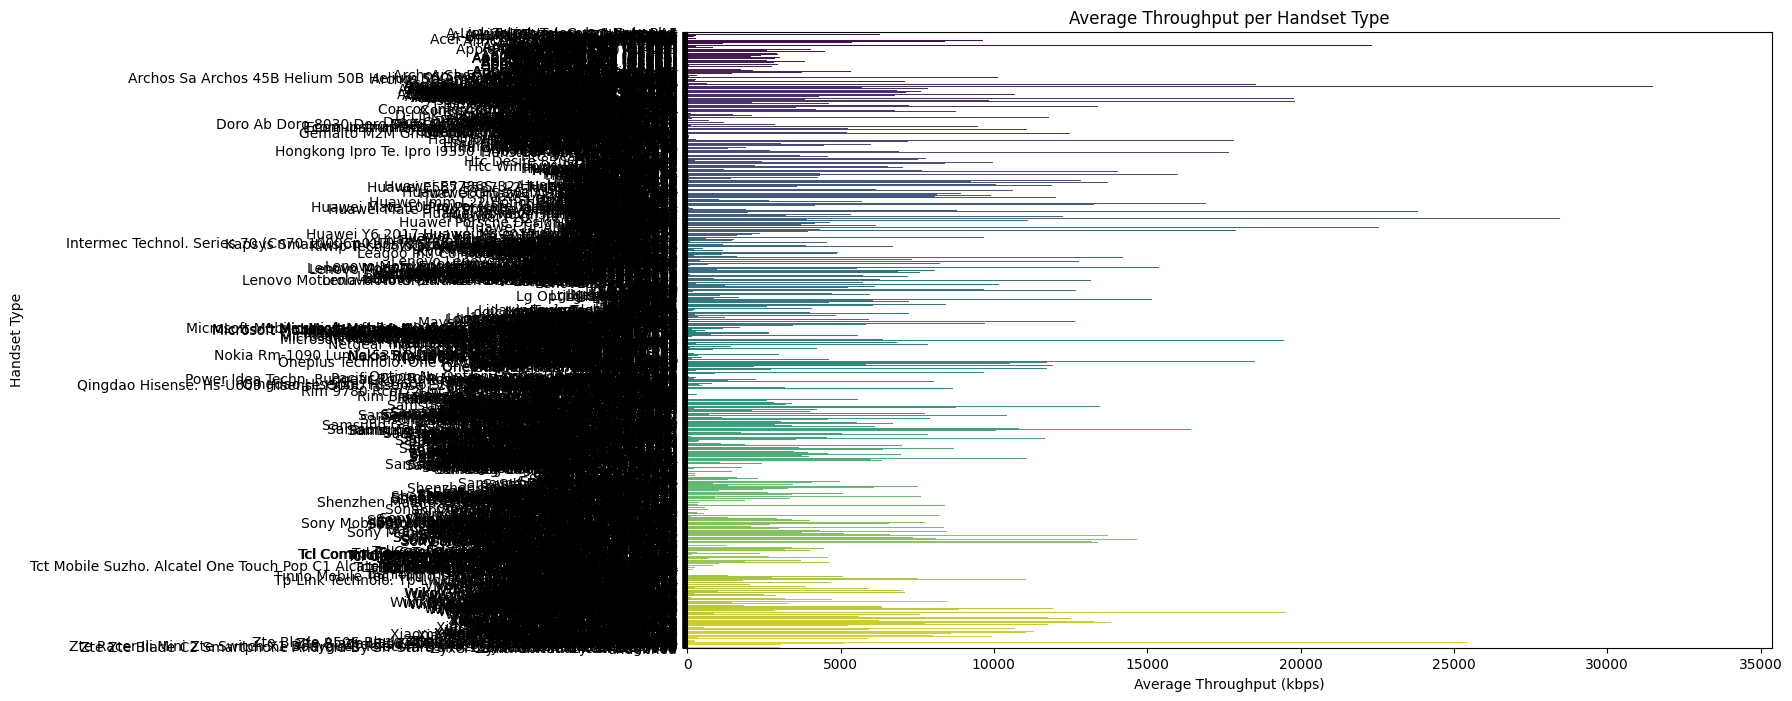

In [75]:
plt.figure(figsize=(14, 8))  # Increase plot size for better readability
sns.barplot(x='Avg Throughput', y='Handset Type', data=throughput_per_handset, palette='viridis')
plt.title('Average Throughput per Handset Type')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Handset Type')
plt.show()

In [77]:
# Average TCP retransmission per handset type

df['Avg TCP Retransmission'] = (df['TCP DL Retrans. Vol (Megabytes)'] + df['TCP UL Retrans. Vol (Megabytes)']) / 2
df.groupby('Handset Type')['Avg TCP Retransmission'].mean().reset_index()

,Handset Type,Avg TCP Retransmission
0,A-Link Telecom I. Cubot A5,0.062893
1,A-Link Telecom I. Cubot Note Plus,308.106500
2,A-Link Telecom I. Cubot Note S,33.680055
3,A-Link Telecom I. Cubot Nova,68.585000
4,A-Link Telecom I. Cubot Power,4.020500
...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,0.700865
1392,Zyxel Communicat. Lte7460,0.062893
1393,Zyxel Communicat. Sbg3600,0.062893
1394,Zyxel Communicat. Zyxel Wah7706,0.066838


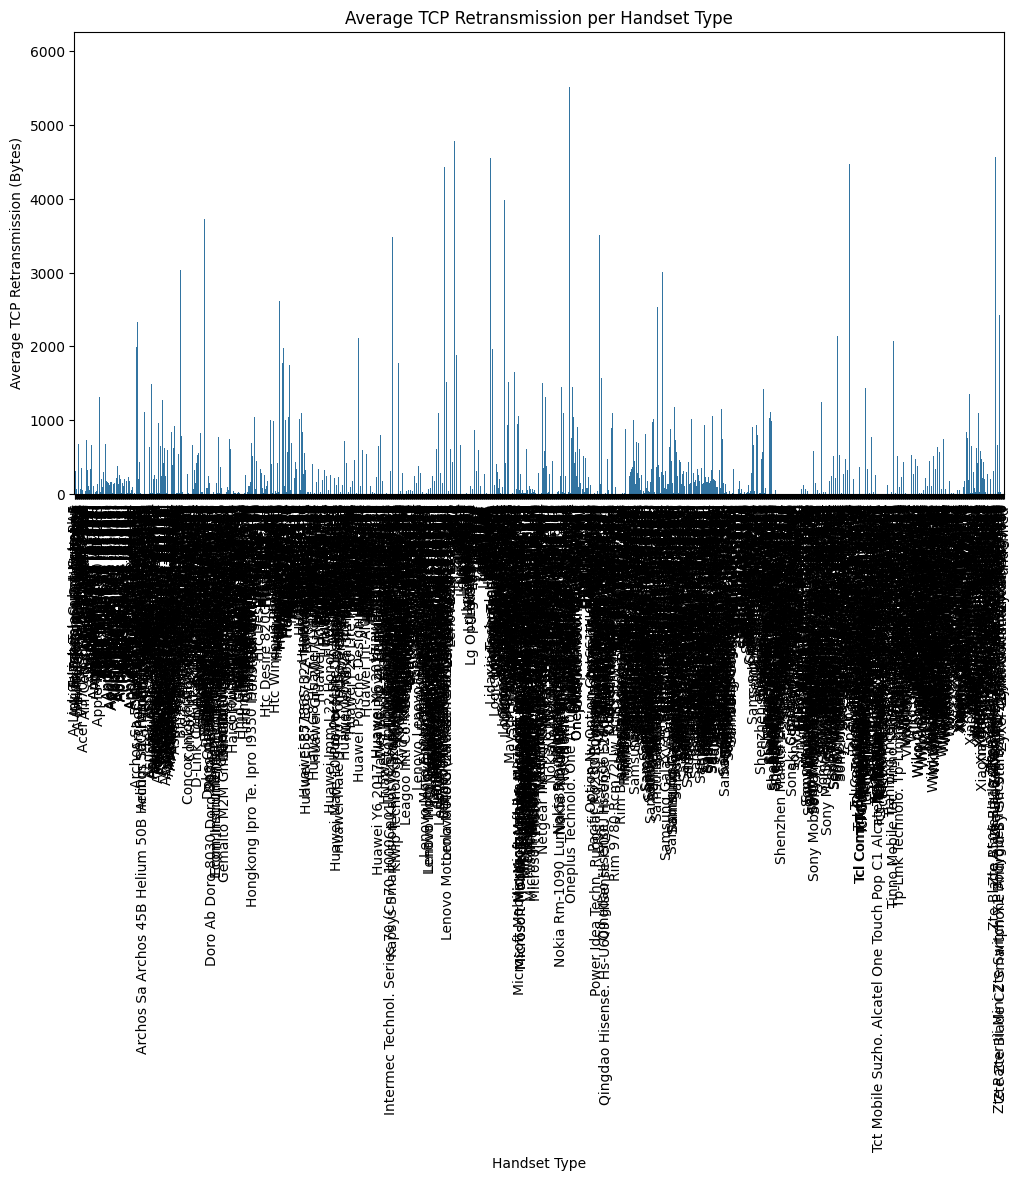

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Handset Type', y='Avg TCP Retransmission', data=tcp_retrans_per_handset)
plt.xticks(rotation=90)
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission (Bytes)')
plt.show()

In [84]:
# K-Means clustering

#  Prepare the data for clustering
clustering_data = df[['Avg TCP Retransmission', 'Avg RTT DL (s)', 'Avg Throughput']].copy()

# Standardizing the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)
#Applying K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

In [ ]:
# Analyzing clusters
cluster_analysis = df.groupby('Cluster').mean()[['Avg TCP Retransmission', 'Avg RTT DL (s)', 'Avg Throughput']]
print(cluster_analysis)


Visualization

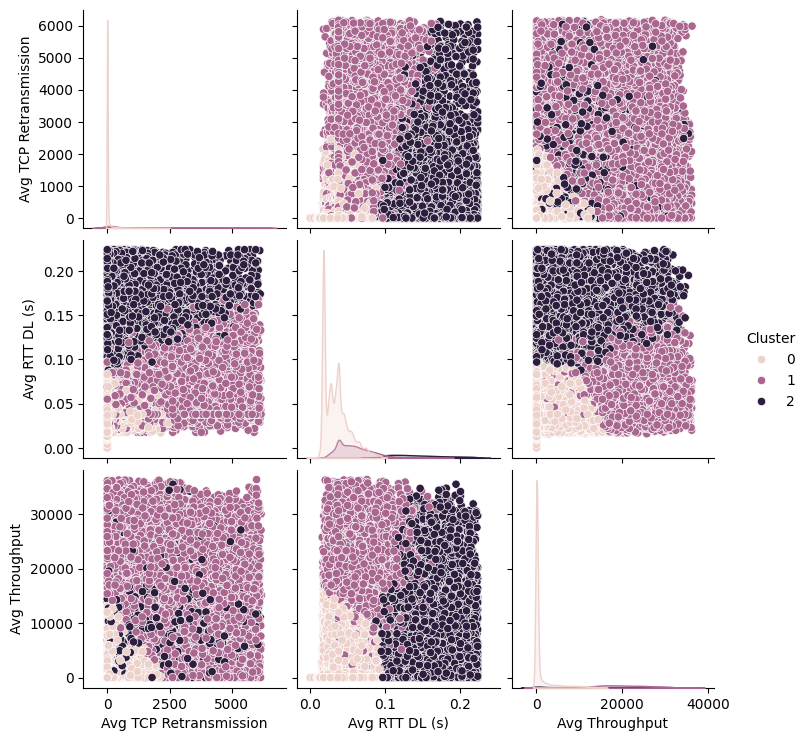

In [90]:
sns.pairplot(df[['Avg TCP Retransmission', 'Avg RTT DL (s)', 'Avg Throughput', 'Cluster']], hue='Cluster')
plt.show()